<a href="https://colab.research.google.com/github/RyuichiKikuchi/660/blob/master/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5MB 7.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [3]:
!pip install numba



In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [5]:

!pip install transformers

     |████████████████████████████████| 660 kB 8.4 MB/s 
     |████████████████████████████████| 883 kB 44.4 MB/s 
     |████████████████████████████████| 3.8 MB 17.4 MB/s 
     |████████████████████████████████| 1.1 MB 52.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893259 sha256=3c824cbd8463a9a2a4863a037b762e12a820d28e9622ded1b0b8aa90d17ad413
  Stored in directory: /root/.cache/pip/wheels/49/25/98/cdea9c79b2d9a22ccc59540b1784b67f06b633378e97f58da2
Successfully built sacremoses


In [0]:
import torch
import pandas as pd
import numpy as np

Enabling and testing the GPU. 

- Navigate to Runtime -> Change runtime type 
- Select GOU 

In [7]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Current device is {dev}")

Current device is cuda


Load training and testing set

In [0]:
train = pd.read_csv("https://fmai-data.s3.amazonaws.com/train.csv.gz", index_col = 0)

In [9]:
train.shape

(280571, 4)

In [10]:
train.head()

,call_title_date,Paragraph,speaker_role,text
370950,Graham Corporation - Special Call 2020-03-25,59,EXECUTIVES,"Sure, John. Certainly we'll pay attention to w..."
84072,"RedHill Biopharma Ltd., 2019 Earnings Call, Ma...",42,EXECUTIVES,"Thanks, Ed. Great question. What we have built..."
194870,"Fagron NV, Q1 2020 Earnings Call, Apr 14, 2020...",82,EXECUTIVES,Our teams are trained to be extremely resilien...
546652,"Superdry Plc, 3 Months Period Ending Jan 04, 2...",20,ANALYSTS,"Well, it's all preordered product. In the next..."
492603,Ultragenyx Pharmaceutical Inc. - Special Call ...,63,EXECUTIVES,"Well, there's been a lot of interest in going ..."


In [0]:
test_example = pd.read_csv("https://fmai-data.s3.amazonaws.com/test_example.csv.gz", index_col = 0)

In [0]:
test = pd.read_csv("https://fmai-data.s3.amazonaws.com/test_actual_small.csv.gz",index_col = 0)

In [12]:
test_example.head(3)

,call_title_date,Paragraph,speaker_role,text
218388,"Conzzeta AG, 2019 Earnings Call, Mar 17, 2020 ...",4,EXECUTIVES,"Thank you, Charlie, for the question. I have a..."
351056,"Lennox International Inc., Q1 2020 Earnings Ca...",16,ANALYSTS,That's very helpful. And maybe just my follow-...
137935,"Boyd Gaming Corporation, Q1 2020 Earnings Call...",67,EXECUTIVES,Just thinking specifically on the Midwest and ...


**Assignment 1 - Spearker Attribution Problem**:
- Given the **text** column, predict whether the speaker role is "EXECUTIVES" or "ANALYSTS"
- Build two models: 
-- Model 1: Use PyTorch to train a deep learning based model that make use of word embedding layer. The layer can be pretrained or randomly initiated. 
-- Model 2: Use a pre-trained transformer-based language model (e.g., BERT, distilbert) as a starting point to train the model.

- Save your model to Google Drive and/or local computer. 
- Accuracy will be the judging metric. 
- A larger test set will be released next meeting for you to formally compare your model performance. Do not overfit (either the train or the test_example dataset). 


Let’s extract the texts and labels(speaker_role) of our training set as numpy ndarrays.

Data Preprocessing

In [0]:
train['speaker_role'] = train['speaker_role'].map(lambda x: 0 if x == 'EXECUTIVES' else 1)

In [14]:
train['speaker_role'].value_counts()

0    197106
1     83465
Name: speaker_role, dtype: int64

In [0]:
test_example['speaker_role'] = test_example['speaker_role'].map(lambda x: 0 if x == 'EXECUTIVES' else 1)

In [16]:
test_example['speaker_role'].value_counts()

0    200
1     80
Name: speaker_role, dtype: int64

In [0]:
# Get the lists of sentences and their labels.
sentences = train.text.values
labels = train.speaker_role.values

## Tokenization & Input Formatting

In this section, we’ll transform our dataset into the format that BERT can be trained on.

### BERT Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT–the below cell will download this for us. We’ll be using the “uncased” version here.

In [18]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [19]:
max_len = 0
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (647 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (512 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Max sentence length:  1064


In [20]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


Original:  Sure, John. Certainly we'll pay attention to what's going on in the governmental markets, the governmental programs. Our first focus, as we noted earlier, as you noted, is toward our employees and to eliminate that anxiety. So we'll deal with that in the immediate term with regard to anything from the government going forward. We'll see what comes out of that, but we're not expecting anything. That's not the basis for why we made the decisions that we made, but we'll deal with that as we go forward.
Token IDs: tensor([  101,  6542,   117,  1287,   119, 22288,  1195,   112,  1325,  2653,
         2209,  1106,  1184,   112,   188,  1280,  1113,  1107,  1103, 11219,
         5809,   117,  1103, 11219,  2648,   119,  3458,  1148,  2817,   117,
         1112,  1195,  2382,  2206,   117,  1112,  1128,  2382,   117,  1110,
         1755,  1412,  4570,  1105,  1106, 11125,  1115, 10507,   119,  1573,
         1195,   112,  1325,  2239,  1114,  1115,  1107,  1103,  5670,  1858,
     

## Training & Validation Split

Divide up our training set to use 90% for training and 10% for validation.

In [21]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

252,513 training samples
28,058 validation samples


We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

There are a few different pre-trained BERT models available. “bert-base-uncased” means the version that has only lowercase letters (“uncased”) and is the smaller version of the two (“base” vs “large”).

In [23]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels = 2,
    output_attentions = False, 
    output_hidden_states = False, 
)

# Tell pytorch to run this model on the GPU.
model.cuda()


optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                      num_warmup_steps = 0, # Default value in run_glue.py
                      num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


And start training.

In [28]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  7,892.    Elapsed: 0:00:15.
  Batch    80  of  7,892.    Elapsed: 0:00:30.
  Batch   120  of  7,892.    Elapsed: 0:00:45.
  Batch   160  of  7,892.    Elapsed: 0:01:00.
  Batch   200  of  7,892.    Elapsed: 0:01:15.
  Batch   240  of  7,892.    Elapsed: 0:01:30.
  Batch   280  of  7,892.    Elapsed: 0:01:45.
  Batch   320  of  7,892.    Elapsed: 0:02:00.
  Batch   360  of  7,892.    Elapsed: 0:02:15.
  Batch   400  of  7,892.    Elapsed: 0:02:30.
  Batch   440  of  7,892.    Elapsed: 0:02:45.
  Batch   480  of  7,892.    Elapsed: 0:03:00.
  Batch   520  of  7,892.    Elapsed: 0:03:15.
  Batch   560  of  7,892.    Elapsed: 0:03:30.
  Batch   600  of  7,892.    Elapsed: 0:03:45.
  Batch   640  of  7,892.    Elapsed: 0:04:00.
  Batch   680  of  7,892.    Elapsed: 0:04:14.
  Batch   720  of  7,892.    Elapsed: 0:04:29.
  Batch   760  of  7,892.    Elapsed: 0:04:44.
  Batch   800  of  7,892.    Elapsed: 0:04:59.
  Batch   840  of

In [29]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.36,0.34,0.86,0:49:14,0:01:42
2,0.33,0.34,0.86,0:49:10,0:01:42
3,0.29,0.35,0.86,0:49:10,0:01:42


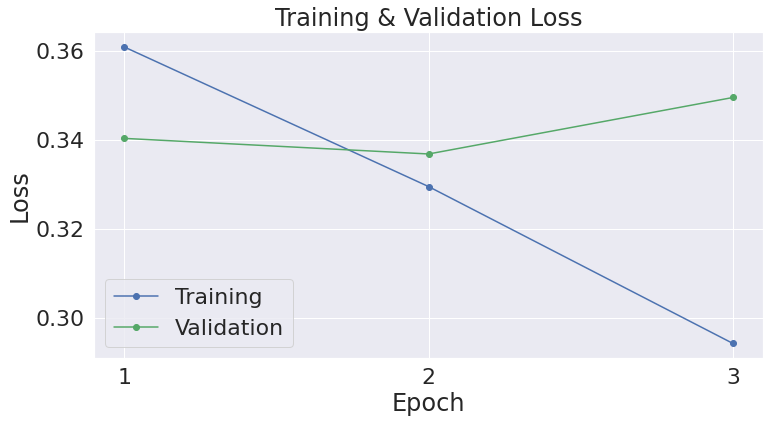

In [42]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
#sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=2)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()


## Test Data Preparation
We’ll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [0]:
# Get the lists of test sentences and their labels.
test_sentences = test_example.text.values
test_labels = test_example.speaker_role.values

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sentences:
  
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Evaluate on Test Set

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [0]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [0]:
from sklearn import linear_model

In [0]:
cls_embeddings_test = np.vstack(predictions)
label=test_example.label.tolist()

In [0]:
logit_mod = linear_model.LogisticRegressionCV(Cs=5, cv=3)
logit_mod.fit(X=cls_embeddings_test, y=label)

LogisticRegressionCV(Cs=5, class_weight=None, cv=3, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
predicted_prob = logit_mod.predict_proba(np.vstack(predictions))[:, 1]

In [0]:
from sklearn import metrics
y_test = [1 if x == "ANALYSTS" else 0 for x in test_example.speaker_role.tolist()] # response

y_pred = np.array([y > 0.5 for y in predicted_prob]).astype(int)
print(metrics.classification_report(y_true=y_test, y_pred=y_pred))
print(f"AUC score: {metrics.roc_auc_score(y_true=y_test, y_score=predicted_prob):.2f}")

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       200
           1       0.74      0.66      0.70        80

    accuracy                           0.84       280
   macro avg       0.80      0.78      0.79       280
weighted avg       0.83      0.84      0.83       280

AUC score: 0.88


In [0]:
sentences = test.text.values

In [0]:
input_ids = []
attention_masks = []


# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_ids.append(encoded_dict['input_ids'])   
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
 
batch_size = 32  

test_prediction_data = TensorDataset(input_ids, attention_masks)
test_prediction_sampler = SequentialSampler(test_prediction_data)
test_prediction_dataloader = DataLoader(test_prediction_data, sampler=test_prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set


model.eval()
testdata_predictions = []

for batch in test_prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  testdata_predictions.append(logits)

In [0]:
predicted_prob = logit_mod.predict_proba(np.vstack(testdata_predictions))[:, 1]
y_pred = np.array([y > 0.5 for y in predicted_prob]).astype(int)
np.savetxt("y_pred_transformer_Ruizhi_Hao.txt", y_pred, fmt='%i')